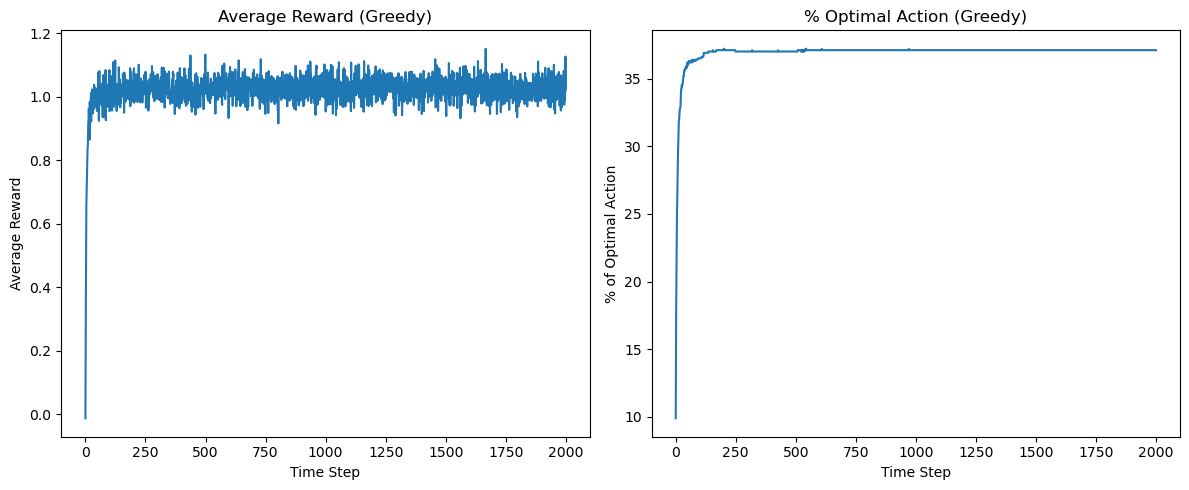

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Step 1: Bandit Environment
# -----------------------------

class BanditEnvironment:
    def __init__(self, k=10):
        self.k = k
        self.true_means = np.random.normal(0, 1, k)  # True mean for each arm

    def pull(self, action):
        return np.random.normal(self.true_means[action], 1)  # Reward ~ N(mean, 1)

    def get_optimal_action(self):
        return np.argmax(self.true_means)


# -----------------------------
# Step 2: Greedy Agent (non-optimistic)
# -----------------------------

class GreedyAgent:
    def __init__(self, k):
        self.k = k
        self.q_values = np.zeros(k)  # Initial Q-values = 0 (non-optimistic)
        self.action_counts = np.zeros(k)

    def select_action(self):
        max_q = np.max(self.q_values)
        best_actions = np.where(self.q_values == max_q)[0]  # Random tiebreaking
        return np.random.choice(best_actions)

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])


# -----------------------------
# Step 3: Simulation Function
# -----------------------------

def simulate(agent_class, env_class, runs=1000, time_steps=2000, k=10):
    avg_rewards = np.zeros(time_steps)
    optimal_action_counts = np.zeros(time_steps)

    for run in range(runs):
        np.random.seed(run)  # Independent random stream
        env = env_class(k)
        agent = agent_class(k)
        optimal_action = env.get_optimal_action()

        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action)
            agent.update(action, reward)

            avg_rewards[t] += reward
            if action == optimal_action:
                optimal_action_counts[t] += 1

    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100
    return avg_rewards, optimal_action_counts


# -----------------------------
# Step 4: Run and Plot Results
# -----------------------------

rewards, optimal_action_percent = simulate(GreedyAgent, BanditEnvironment)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title("Average Reward (Greedy)")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")

plt.subplot(1, 2, 2)
plt.plot(optimal_action_percent)
plt.title("% Optimal Action (Greedy)")
plt.xlabel("Time Step")
plt.ylabel("% of Optimal Action")

plt.tight_layout()
plt.show()


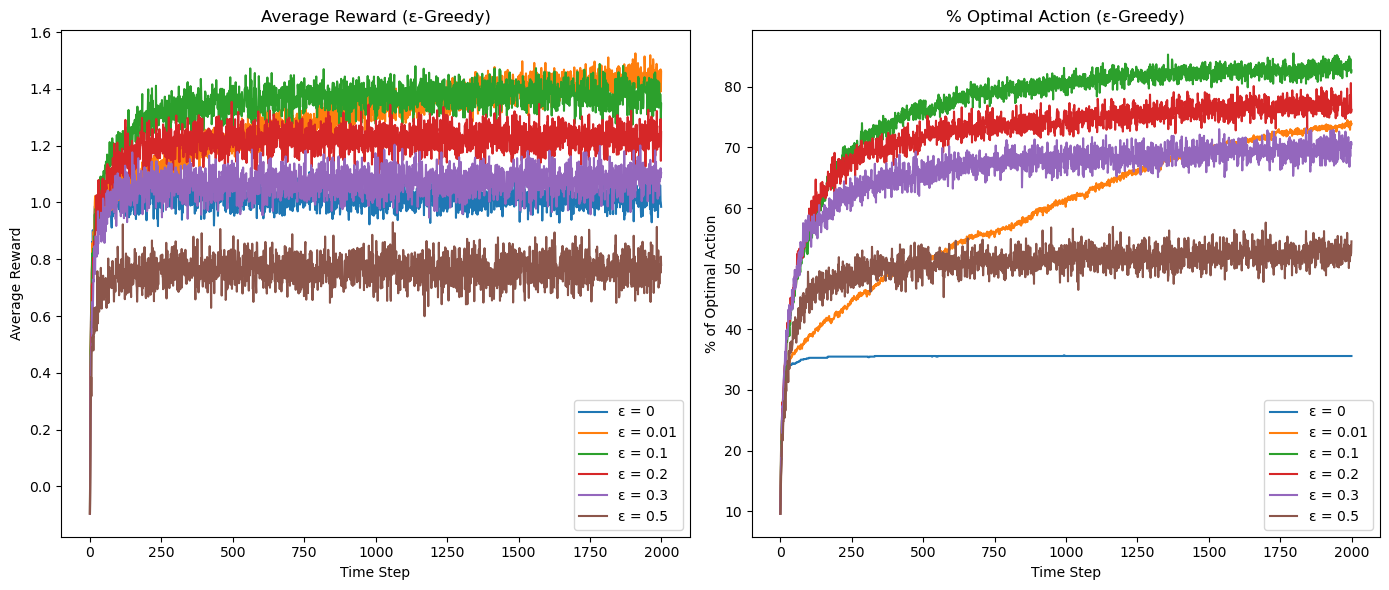

In [20]:
# Define the epsilon-greedy agent
class EpsilonGreedyAgent:
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.q_values = np.zeros(k)
        self.action_counts = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)  
        else:
            max_q = np.max(self.q_values)
            best_actions = np.where(self.q_values == max_q)[0]
            return np.random.choice(best_actions)  # Exploit

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])


# Run experiments for multiple epsilon values
def run_multiple_epsilons(epsilon_values, runs=1000, time_steps=2000, k=10):
    results = {}

    for epsilon in epsilon_values:
        def agent_class(k): return EpsilonGreedyAgent(k, epsilon)
        rewards, optimal_actions = simulate(agent_class, BanditEnvironment, runs=runs, time_steps=time_steps, k=k)
        results[epsilon] = (rewards, optimal_actions)

    return results


# List of epsilon values to test
# %epsilon_values = [0.01, 0.1, 0.2]
epsilon_values = [0, 0.01, 0.1, 0.2, 0.3, 0.5]
epsilon_results = run_multiple_epsilons(epsilon_values)

# Plot the results
plt.figure(figsize=(14, 6))

# Average Reward Plot
plt.subplot(1, 2, 1)
for epsilon, (rewards, _) in epsilon_results.items():
    plt.plot(rewards, label=f"ε = {epsilon}")
plt.title("Average Reward (ε-Greedy)")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")
plt.legend()

# % Optimal Action Plot
plt.subplot(1, 2, 2)
for epsilon, (_, optimal_actions) in epsilon_results.items():
    plt.plot(optimal_actions, label=f"ε = {epsilon}")
plt.title("% Optimal Action (ε-Greedy)")
plt.xlabel("Time Step")
plt.ylabel("% of Optimal Action")
plt.legend()

plt.tight_layout()
plt.show()


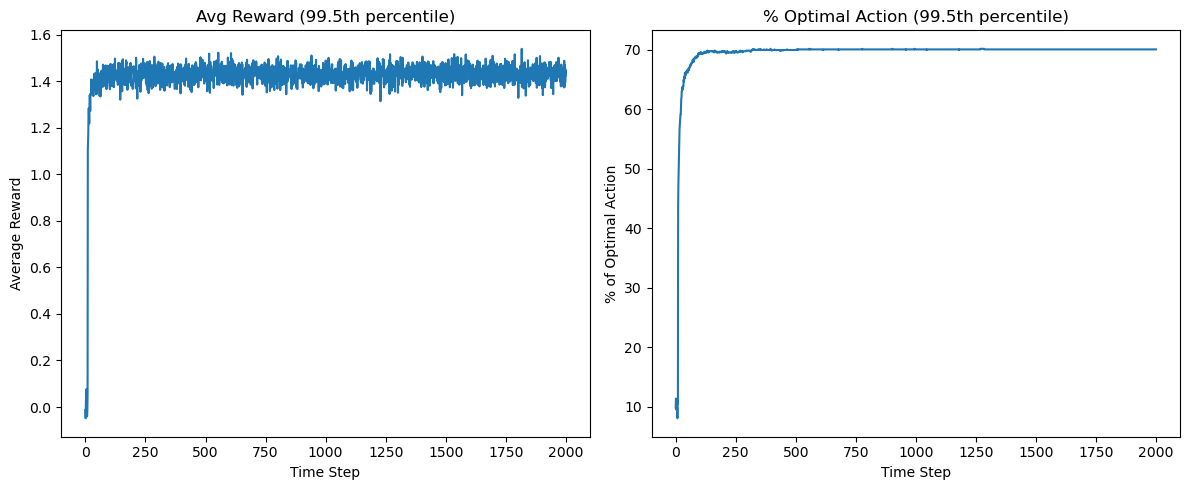

In [11]:
# Updated Optimistic Greedy Agent using 99.5th percentile of max μi
class OptimisticGreedyAgentDynamic:
    def __init__(self, k, initial_value):
        self.k = k
        self.q_values = np.ones(k) * initial_value  # Set to dynamic 99.5th percentile
        self.action_counts = np.zeros(k)

    def select_action(self):
        max_q = np.max(self.q_values)
        best_actions = np.where(self.q_values == max_q)[0]
        return np.random.choice(best_actions)

    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])


# Custom simulation to pass the 99.5th percentile dynamic value into agent
def simulate_optimistic_dynamic(env_class, runs=1000, time_steps=2000, k=10):
    avg_rewards = np.zeros(time_steps)
    optimal_action_counts = np.zeros(time_steps)

    for run in range(runs):
        np.random.seed(run)
        env = env_class(k)

        # Step 1: get max μi
        max_mu = np.max(env.true_means)

        # Step 2: calculate 99.5th percentile of N(max_mu, 1)
        q0_dynamic = max_mu + 2.5758  # z = 99.5th percentile of N(0,1)

        # Step 3: initialize agent with this value
        agent = OptimisticGreedyAgentDynamic(k, q0_dynamic)
        optimal_action = env.get_optimal_action()

        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action)
            agent.update(action, reward)

            avg_rewards[t] += reward
            if action == optimal_action:
                optimal_action_counts[t] += 1

    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100
    return avg_rewards, optimal_action_counts


# Run updated simulation
rewards_dynamic, optimal_dynamic = simulate_optimistic_dynamic(BanditEnvironment)

# Plot the corrected results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_dynamic)
plt.title("Avg Reward (99.5th percentile)")
plt.xlabel("Time Step")
plt.ylabel("Average Reward")

plt.subplot(1, 2, 2)
plt.plot(optimal_dynamic)
plt.title("% Optimal Action (99.5th percentile)")
plt.xlabel("Time Step")
plt.ylabel("% of Optimal Action")

plt.tight_layout()
plt.show()


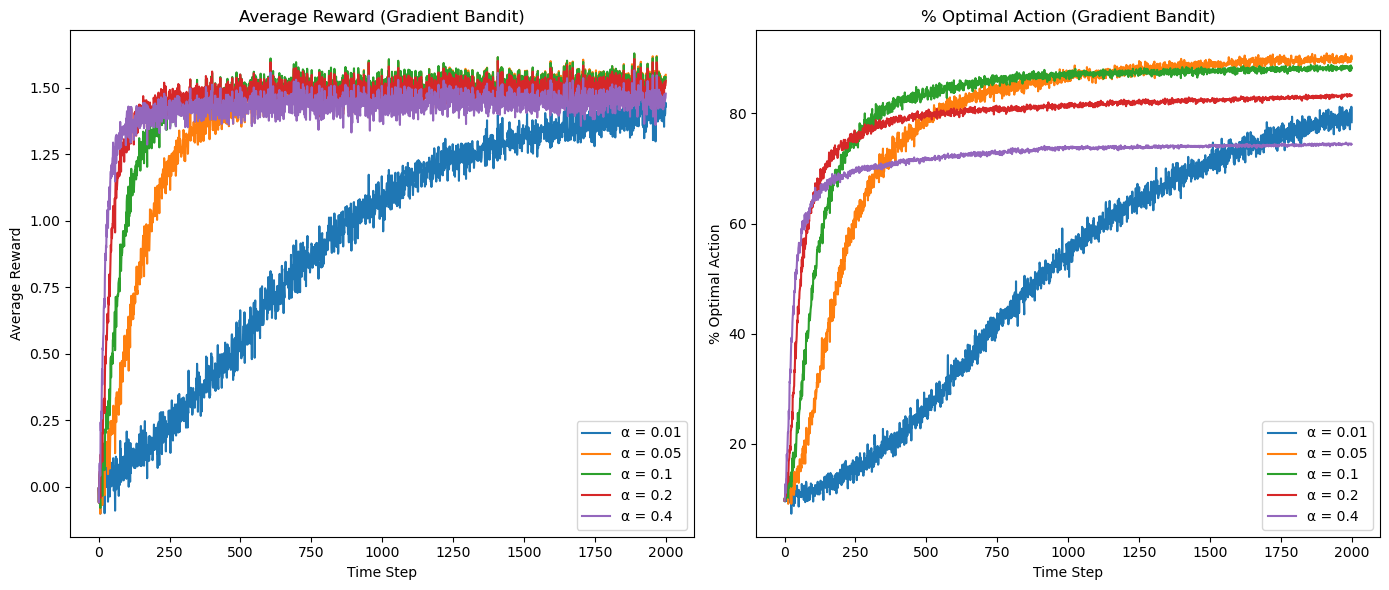

In [22]:
# Gradient Bandit Agent
class GradientBanditAgent:
    def __init__(self, k, alpha=0.1, use_baseline=True):
        self.k = k
        self.alpha = alpha
        self.preferences = np.zeros(k)
        self.avg_reward = 0
        self.use_baseline = use_baseline
        self.time = 0

    def get_action_probabilities(self):
        exp_prefs = np.exp(self.preferences - np.max(self.preferences))  # for numerical stability
        return exp_prefs / np.sum(exp_prefs)

    def select_action(self):
        probabilities = self.get_action_probabilities()
        return np.random.choice(self.k, p=probabilities)

    def update(self, action, reward):
        self.time += 1
        probabilities = self.get_action_probabilities()

        if self.use_baseline:
            self.avg_reward += (reward - self.avg_reward) / self.time
            baseline = self.avg_reward
        else:
            baseline = 0

        for a in range(self.k):
            if a == action:
                self.preferences[a] += self.alpha * (reward - baseline) * (1 - probabilities[a])
            else:
                self.preferences[a] -= self.alpha * (reward - baseline) * probabilities[a]


# Run simulation for Gradient Bandit Agent
def simulate_gradient_bandit(runs=1000, time_steps=2000, k=10, alpha=0.1):
    avg_rewards = np.zeros(time_steps)
    optimal_action_counts = np.zeros(time_steps)

    for run in range(runs):
        np.random.seed(run)
        env = BanditEnvironment(k)
        agent = GradientBanditAgent(k, alpha=alpha)
        optimal_action = env.get_optimal_action()

        for t in range(time_steps):
            action = agent.select_action()
            reward = env.pull(action)
            agent.update(action, reward)

            avg_rewards[t] += reward
            if action == optimal_action:
                optimal_action_counts[t] += 1

    avg_rewards /= runs
    optimal_action_counts = (optimal_action_counts / runs) * 100
    return avg_rewards, optimal_action_counts


def run_gradient_bandit_for_alphas(alpha_values, runs=1000, time_steps=2000, k=10):
    results = {}
    for alpha in alpha_values:
        avg_rewards = np.zeros(time_steps)
        optimal_action_counts = np.zeros(time_steps)

        for run in range(runs):
            np.random.seed(run)
            env = BanditEnvironment(k)
            agent = GradientBanditAgent(k, alpha=alpha)
            optimal_action = env.get_optimal_action()

            for t in range(time_steps):
                action = agent.select_action()
                reward = env.pull(action)
                agent.update(action, reward)

                avg_rewards[t] += reward
                if action == optimal_action:
                    optimal_action_counts[t] += 1

        avg_rewards /= runs
        optimal_action_counts = (optimal_action_counts / runs) * 100
        results[alpha] = (avg_rewards, optimal_action_counts)

    return results


alpha_values = [0.01, 0.05, 0.1, 0.2, 0.4]
gradient_results = run_gradient_bandit_for_alphas(alpha_values, runs=1000)

# Plotting
plt.figure(figsize=(14, 6))

# Plot average rewards
plt.subplot(1, 2, 1)
for alpha, (rewards, _) in gradient_results.items():
    plt.plot(rewards, label=f'α = {alpha}')
plt.title('Average Reward (Gradient Bandit)')
plt.xlabel('Time Step')
plt.ylabel('Average Reward')
plt.legend()

# Plot % optimal action
plt.subplot(1, 2, 2)
for alpha, (_, optimal) in gradient_results.items():
    plt.plot(optimal, label=f'α = {alpha}')
plt.title('% Optimal Action (Gradient Bandit)')
plt.xlabel('Time Step')
plt.ylabel('% Optimal Action')
plt.legend()

plt.tight_layout()
plt.show()
